In [2]:
%load_ext autoreload
%autoreload 2

### Imports

In [3]:
import json
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import time
from tqdm import tqdm
from typing import List
#from typing import Union

from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import toml
import torch

/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from nb_utils.eval_utils import TEST, VALID, TRAIN, DUMMY
from nb_utils.eval_utils import EVAL_METRICS_CATALOG, EVAL_METRICS_SHORTLIST
from nb_utils.eval_utils import COL_SOURCE, COL_TARGET, COL_EDGE, COL_NODE, DEGREE, IN_DEGREE, OUT_DEGREE
from nb_utils.eval_utils import create_entity_attr_aware_test_sets
from nb_utils.eval_utils import setup_wandb_result_tracker, run_experiment_and_log_wandb
from nb_utils.eval_utils import compute_node_degrees_in_out
from nb_utils.eval_utils import load_kge_model
from nb_utils.eval_utils import create_entity_attr_aware_test_sets
from nb_utils.eval_utils import make_results_dict_all_rel


from nb_utils.config import ARTIFACT_REGISTRY_TOML_PATH, EntityType
from nb_utils.config import load_toml, ModelRegistryConfig, EvaluationConfig
from nb_utils.config import GraphRegistryConfig, EntityType
from nb_utils.config import PROTEIN, DRUG, DISEASE
from nb_utils.eval_utils import ENT_ASSOC_REL_NAMES, EVAL_METRIC_REALISTIC, EVAL_NODE_HEAD, EVAL_NODE_TAIL
from nb_utils.eval_utils import PROT_ASSOC_REL_NAMES, test_rel_list_validity, ENT_ASSOC_REL_NAMES
from nb_utils.eval_utils import TEST, TRAIN, VALID, DUMMY
from nb_utils.eval_utils import TEST_RESTRICTED_PROTEIN, TEST_RESTRICTED_DISEASE, TEST_RESTRICTED_DRUG
from nb_utils.eval_utils import ENT_SPECIFIC_TEST_SET_STUBS

### load data

1. add the paths to the following models and biokg files in ./nb_utils/artifact_registry.toml


In [5]:
ROTATE = "rotate-otxtubeb"
BIOBLP_D = "bioblpd-38uz9fjs-16-03-2023" 
BIOBLP_P = "rotate-bioblp-p-4o6x9h96"
BIOBLP_M = "rotate-bioblp-m-1r75g9na"
BIOBLP_D_old = "bioblpd-38uz9fjs"  # older pykeen and BioBLP version
#BIOBLP_P = "bioblpp-cttc3ucm" # this was not pretrained
#BIOBLP_M = "bioblpm-5rxz3k57" # this was not pretrained


In [6]:
toml_path = ARTIFACT_REGISTRY_TOML_PATH
model_reg_cfg = ModelRegistryConfig.from_toml(toml_path)
model_registry_paths = model_reg_cfg.registered_model_paths
model_training_paths = model_reg_cfg.registered_model_training_triples_paths

In [7]:
graph_cfg = GraphRegistryConfig.from_toml(ARTIFACT_REGISTRY_TOML_PATH)


### load triples data

In [8]:
# load training splits
MODEL_ID = BIOBLP_D
train = TriplesFactory.from_path_binary(model_training_paths[MODEL_ID])


valid, test = [TriplesFactory.from_path(f,
                                        entity_to_id=train.entity_to_id,
                                        relation_to_id=train.relation_to_id)
               for f in (map(graph_cfg.biokgb_data_splits.get, [VALID, TEST]))]


In [16]:
triples_dict = {
    TEST: test,
    VALID: valid,
    TRAIN: train,    
}

### Split test triples conditional on whether they contain entities whose properties were encoded in BIOBLP-X vs not

In [11]:
def create_entity_type_attr_aware_subsets(entity_type_w_attribute: str, 
                                       graph_cfg: GraphRegistryConfig,
                                       train: TriplesFactory, 
                                       test: TriplesFactory):
    entity_metadata_path = graph_cfg.biokgb_entity_type_metadata_paths.get(entity_type_w_attribute)
    entity_attribute_path = graph_cfg.biokgb_entity_attribute_paths.get(entity_type_w_attribute)
    
    # create a subset of biokg entities of type {entity_type_w_attribute} 
    entities = pd.read_csv(entity_metadata_path, sep="\t", names=[entity_type_w_attribute, COL_EDGE, "node_type"])
    entity_set = set(entities[entity_type_w_attribute].values)
    print(f"# {entity_type_w_attribute} entities in larger biokg metadata files: {len(entity_set)}")

    # create a set of {entity_type_w_attribute} entities for which we have attr descriptions (e.g.: text for Diseases)
    # TODO: Currently a quick hack. Standardise input reading
    try:
        entity_w_attr_df = pd.read_json(entity_attribute_path, orient="index").reset_index()
        entity_w_attr_df.rename(columns={"index": entity_type_w_attribute, 0: "attr"}, inplace=True)
    except:
        entity_w_attr_df = pd.read_csv(entity_attribute_path, sep="\t", header=0, names=[entity_type_w_attribute, "attr"])
    entity_attr_set = set(entity_w_attr_df[entity_type_w_attribute].values)
    print(f"# {entity_type_w_attribute} entities for which we have attributes: {len(entity_attr_set)}")
    return entity_set, entity_attr_set
    


In [12]:
prot_all, prot_attr = create_entity_type_attr_aware_subsets(PROTEIN, graph_cfg, train, test)
dis_all, dis_attr = create_entity_type_attr_aware_subsets(DISEASE, graph_cfg, train, test)
drug_all, drug_attr = create_entity_type_attr_aware_subsets(DRUG, graph_cfg, train, test)

# protein entities in larger biokg metadata files: 122902
# protein entities for which we have attributes: 121988
# disease entities in larger biokg metadata files: 11347
# disease entities for which we have attributes: 11347
# drug entities in larger biokg metadata files: 13580
# drug entities for which we have attributes: 10815


### obtain entity counts

In [9]:
biokg_triples = train.num_triples+valid.num_triples+test.num_triples
biokg_ents = set(train.entity_to_id).union(set(test.entity_to_id).union(valid.entity_to_id))
print(f"# unique entities in biokg graphs (all splits): {len(biokg_ents)}")                                        
print(f"# Triples in biokg graphs (all splits): {biokg_triples}")

# unique entities in biokg graphs (all splits): 106047
# Triples in biokg graphs (all splits): 1852262


In [13]:
print(f"#{PROTEIN} entities in BioKG graph: {len(biokg_ents.intersection(prot_all))}")
print(f"#{DRUG} entities in BioKG graph: {len(biokg_ents.intersection(drug_all))}")
print(f"#{DISEASE} entities in BioKG graph: {len(biokg_ents.intersection(dis_all))}")

#protein entities in BioKG graph: 59568
#drug entities in BioKG graph: 8614
#disease entities in BioKG graph: 5814


In [14]:
print(f"#{PROTEIN} entities with Attributes in BioKG graph: {len(biokg_ents.intersection(prot_attr))}")
print(f"#{DRUG} entities with Attributes in BioKG graph: {len(biokg_ents.intersection(drug_attr))}")
print(f"#{DISEASE} entities with Attributes in BioKG graph: {len(biokg_ents.intersection(dis_attr))}")

#protein entities with Attributes in BioKG graph: 59455
#drug entities with Attributes in BioKG graph: 7641
#disease entities with Attributes in BioKG graph: 5814


note, the entity counts obtained from biokg metadata files **below** are larger than actual number of entities in biokg graph. Don't be alarmed, authors intend it.

In [17]:
LIST_ENTITY_TYPES_W_ATTRIBUTE = [DRUG, PROTEIN, DISEASE]

# note, the entity counts in biokg metadata files are larger than actual number of entities in biokg graph. Don't be alarmed, authors intend it.
for ent_type in LIST_ENTITY_TYPES_W_ATTRIBUTE:
    print(f"Creating test sets with triples restricted to containing {ent_type}")
    test_triples_incl_ent_prop, test_triples_excl_ent_prop = create_entity_attr_aware_test_sets(entity_type_w_attribute=ent_type,
                                                                                            graph_cfg=graph_cfg,
                                                                                            train=train,
                                                                                            test=test) 
    triples_dict.update({ENT_SPECIFIC_TEST_SET_STUBS[ent_type]: test_triples_incl_ent_prop})
    
    
triples_dict.keys()

Creating test sets with triples restricted to containing drug


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


# drug entities in larger biokg metadata files:(pre-benchmark removal): 13580
# drug entities for which we have attributes: 10815
Creating test sets with triples restricted to containing protein
# protein entities in larger biokg metadata files:(pre-benchmark removal): 122902
# protein entities for which we have attributes: 121988


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


Creating test sets with triples restricted to containing disease
# disease entities in larger biokg metadata files:(pre-benchmark removal): 11347
# disease entities for which we have attributes: 11347


Reconstructing all label-based triples. This is expensive and rarely needed.


dict_keys(['test', 'valid', 'train', 'TEST_RESTRICTED_DRUG', 'TEST_RESTRICTED_PROTEIN', 'TEST_RESTRICTED_DISEASE'])

In [17]:
# create test subsets of triples that are aware of the special entities with attributes
print(f"# triples originally in test: {test.num_triples}, valid: {valid.num_triples}")
for ent_type in LIST_ENTITY_TYPES_W_ATTRIBUTE:
    print(f"# test triples with {ent_type} nodes: {triples_dict[ENT_SPECIFIC_TEST_SET_STUBS[ent_type]].num_triples}")


# triples originally in test: 185227, valid: 185226
# test triples with drug nodes: 123636
# test triples with protein nodes: 54064
# test triples with disease nodes: 17063


## Plots

#### node degree distribution within training set

In [18]:
from nb_utils.eval_utils import NodeDegreeEvalAnalyser
nde_ = NodeDegreeEvalAnalyser(train_triples=train,
                           rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)

train_triples_ent_w_attr_df = nde_.prep_test_data(train)


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [19]:
degree_df = pd.DataFrame.from_dict(nde_.node_train_degree_dict, orient='index').reset_index()
degree_df = degree_df.rename(columns = {'index': 'ent', 0: 'degree'})
degree_df.degree.describe()

count    106047.000000
mean         27.946269
std         118.999582
min           1.000000
25%           2.000000
50%           4.000000
75%          10.000000
max        2448.000000
Name: degree, dtype: float64

In [20]:
prot_degree_df = degree_df[degree_df.ent.isin(prot_all)]
dis_degree_df = degree_df[degree_df.ent.isin(dis_all)]
drug_degree_df = degree_df[degree_df.ent.isin(drug_all)]

prot_degree_df.degree.describe()

count    59568.000000
mean         9.600121
std         19.327112
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max        480.000000
Name: degree, dtype: float64

In [23]:
drug_degree_df.degree.describe()

count    8614.000000
mean      218.847690
std       351.239731
min         1.000000
25%         2.000000
50%         6.000000
75%       368.500000
max      1942.000000
Name: degree, dtype: float64

In [21]:
dis_degree_df.degree.describe()

count    5814.000000
mean       25.888201
std        85.373106
min         1.000000
25%         3.000000
50%         5.000000
75%        15.000000
max      2448.000000
Name: degree, dtype: float64

let's check out the disease entity with apparently 2448 links!

In [26]:
dis_degree_df[dis_degree_df['degree']==2448]

,ent,degree
84914,D008106,2448.0


In [204]:
train_df[train_df['tgt']=='D008106']

,src,rel,tgt
568,A0A0R4IKU3,PROTEIN_DISEASE_ASSOCIATION,D008106
573,A0A0R4IQZ2,PROTEIN_DISEASE_ASSOCIATION,D008106
649,A0A1S6M251,PROTEIN_DISEASE_ASSOCIATION,D008106
669,A0A4X1UM84,PROTEIN_DISEASE_ASSOCIATION,D008106
679,A0AUR5,PROTEIN_DISEASE_ASSOCIATION,D008106
...,...,...,...
1448521,Q9Z1Q5,PROTEIN_DISEASE_ASSOCIATION,D008106
1448720,Q9Z250,PROTEIN_DISEASE_ASSOCIATION,D008106
1448887,Q9Z2C9,PROTEIN_DISEASE_ASSOCIATION,D008106
1448990,Q9Z2J0,PROTEIN_DISEASE_ASSOCIATION,D008106


### distributions of node degree in test sets

In [30]:
from nb_utils.eval_utils import NodeDegreeEvalAnalyser
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE

test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde_ = NodeDegreeEvalAnalyser(train_triples=train,
                           rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)

test_triples_ent_w_attr_df = nde_.prep_test_data(test_triples_incl_ent_prop)

test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde_._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [31]:
# we see the count of triples where the {ENTITY_TYPE_W_ATTR_ENCODE} occurs as the head/src vs tail/tgt
triples_by_node_endpoint = {node_endpoint: len(test_triples_by_node_endpoint_to_predict[node_endpoint]) for node_endpoint in [COL_SOURCE, COL_TARGET]}
triples_by_node_endpoint

{'src': 554, 'tgt': 16509}

In [32]:
print(f"Counts of triples with {ENTITY_TYPE_W_ATTR_ENCODE} in src/tgt position {triples_by_node_endpoint}")
print(f"i.e.,{round((triples_by_node_endpoint[COL_SOURCE])/(triples_by_node_endpoint[COL_TARGET]+triples_by_node_endpoint[COL_SOURCE])*100, 2)}% test triples with {ENTITY_TYPE_W_ATTR_ENCODE} occuring in source position than in tail position")

Counts of triples with disease in src/tgt position {'src': 554, 'tgt': 16509}
i.e.,3.25% test triples with disease occuring in source position than in tail position


In [33]:
NODE_ENDPOINT_TO_PREDICT = COL_SOURCE
print(f"Restricting analysis to relations where we predict '{ENTITY_TYPE_W_ATTR_ENCODE}' as '{NODE_ENDPOINT_TO_PREDICT}'")

Restricting analysis to relations where we predict 'disease' as 'src'


In [34]:
rels_for_ent_w_attr_as_src = ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE][COL_SOURCE]
train_triples_ent_w_attr_df[train_triples_ent_w_attr_df[COL_EDGE].isin(rels_for_ent_w_attr_as_src)][f'{COL_SOURCE}_training_degree'].describe()

count    7284.000000
mean       48.878913
std        93.734147
min         1.000000
25%        10.000000
50%        24.000000
75%        62.000000
max      1654.000000
Name: src_training_degree, dtype: float64

In [35]:
rels_w_ent_w_attr_as_tgt = ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE][COL_TARGET]
train_triples_ent_w_attr_df[train_triples_ent_w_attr_df[COL_EDGE].isin(rels_w_ent_w_attr_as_tgt)][f'{COL_TARGET}_training_degree'].describe()

count    143230.000000
mean        320.526035
std         461.623944
min           1.000000
25%          43.000000
50%         149.000000
75%         390.000000
max        2448.000000
Name: tgt_training_degree, dtype: float64

In [36]:
COL_ENT = "ent"
COL_ENT_DEGREE = "ent_training_deg"
fused_train_triple_ents = pd.DataFrame(columns=[COL_ENT, COL_ENT_DEGREE])
for node_position, rels in ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE].items():
    print(node_position)
    rels_w_ent_w_attr_in_node_position = ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE][node_position]
    print(rels_w_ent_w_attr_in_node_position)
    train_triples_w_ent_in_node_position =  train_triples_ent_w_attr_df[train_triples_ent_w_attr_df[COL_EDGE].isin(rels_w_ent_w_attr_in_node_position)]
    print(train_triples_w_ent_in_node_position.rel.unique())
    train_triples_w_ent_in_node_position_sliced = train_triples_w_ent_in_node_position[[node_position, f"{node_position}_training_degree"]]
    train_triples_w_ent_in_node_position_sliced.rename(columns={
        node_position: COL_ENT,
        f"{node_position}_training_degree": COL_ENT_DEGREE,
    }, inplace=True)
    fused_train_triple_ents = pd.concat([fused_train_triple_ents, train_triples_w_ent_in_node_position_sliced])


src
['DISEASE_PATHWAY_ASSOCIATION', 'DISEASE_GENETIC_DISORDER']
['DISEASE_GENETIC_DISORDER' 'DISEASE_PATHWAY_ASSOCIATION']
tgt
['PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION']
['PROTEIN_DISEASE_ASSOCIATION' 'DRUG_DISEASE_ASSOCIATION']


/tmp/ipykernel_56/3684726652.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_triples_w_ent_in_node_position_sliced.rename(columns={
/tmp/ipykernel_56/3684726652.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_triples_w_ent_in_node_position_sliced.rename(columns={


In [37]:
train_triples_w_ent_in_node_position['rel'].unique()



array(['PROTEIN_DISEASE_ASSOCIATION', 'DRUG_DISEASE_ASSOCIATION'],
      dtype=object)

In [38]:
fused_train_triple_deg_distr = fused_train_triple_ents.ent_training_deg.describe()
fused_train_triple_deg_distr

count    150514.000000
mean        307.379898
std         454.540882
min           1.000000
25%          40.000000
50%         140.000000
75%         379.000000
max        2448.000000
Name: ent_training_deg, dtype: float64

In [39]:
fused_train_triple_ents[fused_train_triple_ents[COL_ENT_DEGREE]>=fused_train_triple_deg_distr['75%']]

,ent,ent_training_deg
13530,D000544,382.0
13531,D000544,382.0
13532,D000544,382.0
13571,D001171,384.0
13572,D001171,384.0
...,...,...
1449472,D013375,409.0
1449475,D001172,555.0
1449562,D011471,1823.0
1449575,D012640,853.0


In [40]:
dis_degree_df.degree.describe()

count    5814.000000
mean       25.888201
std        85.373106
min         1.000000
25%         3.000000
50%         5.000000
75%        15.000000
max      2448.000000
Name: degree, dtype: float64

In [41]:
#ents_subset_top25pc = fused_train_triple_ents[fused_train_triple_ents[COL_ENT_DEGREE]>=fused_train_triple_deg_distr['75%']][COL_ENT].values
ents_subset_top25pc = fused_train_triple_ents[fused_train_triple_ents[COL_ENT_DEGREE]>=dis_degree_df.degree.describe()['75%']][COL_ENT].unique()
len(ents_subset_top25pc)

1510

In [42]:
from nb_utils.eval_utils import get_unique_endpoint_entities_in_testset_of_given_degree

DEGREE = 1
unique_ent_w_attr_as_src_in_test = get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT], 
                                                                                           degree=DEGREE, node_endpoint_type=COL_SOURCE)
print(f"# unique entities of type '{ENTITY_TYPE_W_ATTR_ENCODE}' of training degree {DEGREE} in associated triples where it occurs in position {NODE_ENDPOINT_TO_PREDICT}: {len(unique_ent_w_attr_as_src_in_test)}")



# unique entities of type 'disease' of training degree 1 in associated triples where it occurs in position src: 1


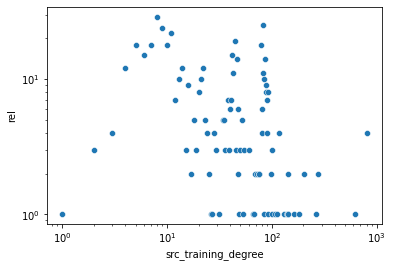

In [50]:
import seaborn as sns
test_triples_ent_as_src = test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT]
ent_src_degrees = test_triples_ent_as_src.groupby(['src_training_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=ent_src_degrees, x='src_training_degree', y='rel')
plt.xscale('log')
plt.yscale('log')

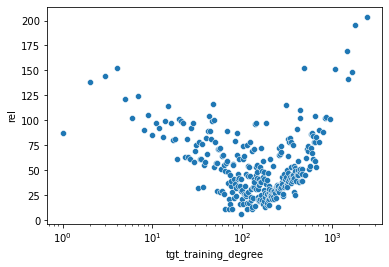

In [52]:
import seaborn as sns
test_triples_ent_as_tgt = test_triples_by_node_endpoint_to_predict[COL_TARGET]
ent_tgt_degrees = test_triples_ent_as_tgt.groupby(['tgt_training_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=ent_tgt_degrees, x='tgt_training_degree', y='rel')
plt.xscale('log')
#plt.yscale('log')

<AxesSubplot:ylabel='tgt_training_degree'>

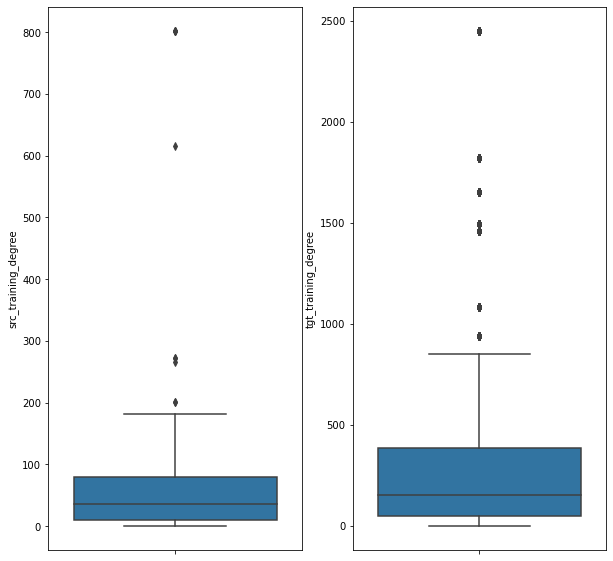

In [53]:
plot, ax = plt.subplots(1, 2, figsize=(10,10))
sns.boxplot(ax=ax[0], y=test_triples_ent_as_src['src_training_degree'])
sns.boxplot(ax=ax[1], y=test_triples_ent_as_tgt['tgt_training_degree'])

### define plotting logic

In [18]:
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_multi_models
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_single_model
from nb_utils.eval_utils import EVAL_METRICS_CATALOG, get_unique_endpoint_entities_in_testset_of_given_degree
from nb_utils.eval_utils import INVERSE_HARMONIC_MEAN_RANK
from nb_utils.eval_utils import HITS_AT_1, HITS_AT_3, HITS_AT_10
from nb_utils.plot_utils import merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff
import matplotlib.ticker as ticker

In [19]:
from nb_utils.eval_utils import NodeDegreeEvalAnalyser


In [106]:
NODE_DEGREE_EVAL_RESULTS_DIR = Path("metrics/node_degree_eval_lp/combined_spotlight_ent_as_src_and_tgt")
#NODE_DEGREE_EVAL_RESULTS_DIR = Path("metrics/node_degree_eval_lp/spotlight_ent_as_src")#_and_tgt")

ent_type_specific_models = {
    DISEASE: [ROTATE, BIOBLP_D],
    PROTEIN: [ROTATE, BIOBLP_P],
    DRUG: [ROTATE, BIOBLP_M]
}
eval_out_dir = NODE_DEGREE_EVAL_RESULTS_DIR
results_dicts = {}
for ent_type, model_list in ent_type_specific_models.items():
    print(ent_type, model_list)
    results_dicts.update({ent_type: {}})
    for model_name in model_list:
        file_name = f"node-degree-eval-{model_name}-spotlight-{ent_type}-as-src-and-tgt.json"
        #file_name = f"node-degree-eval-{model_name}-spotlight-{ent_type}-as-src.json"
        with open(eval_out_dir.joinpath(file_name), 'r') as f:
            result = json.load(f)       
            results_dicts[ent_type].update({model_name: result})

disease ['rotate-otxtubeb', 'bioblpd-38uz9fjs-16-03-2023']
protein ['rotate-otxtubeb', 'rotate-bioblp-p-4o6x9h96']
drug ['rotate-otxtubeb', 'rotate-bioblp-m-1r75g9na']


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


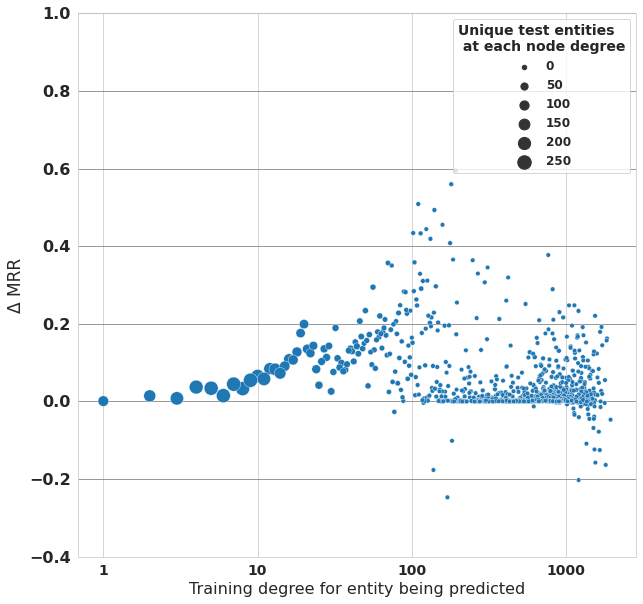

,degree,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,count,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,148.0,0.103448,0.241379,0.310345,0.413793,0.204842,29,0.000000,0.000000,0.000000,0.000000,0.001497,4,0.103448,0.241379,0.310345,0.413793,0.203345
1,4.0,0.073016,0.082540,0.095238,0.098413,0.083203,315,0.041270,0.050794,0.050794,0.050794,0.046082,264,0.031746,0.031746,0.044444,0.047619,0.037121
2,2.0,0.039648,0.048458,0.052863,0.057269,0.046961,227,0.030837,0.035242,0.035242,0.035242,0.032517,192,0.008811,0.013216,0.017621,0.022026,0.014444


In [252]:
from nb_utils.plot_utils import plot_node_degree_analysis_multimodel_lp_eval_diff
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE
BIOBLP_MODEL_ID = BIOBLP_D
ROTATE_MODEL_ID = ROTATE

test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde = NodeDegreeEvalAnalyser(train_triples=train,
                             rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)
test_triples_ent_w_attr_df = nde.prep_test_data(test_triples_incl_ent_prop)

merged_bioblpd_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                                                       bioblp_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][BIOBLP_MODEL_ID],
                                                                                       rotate_model_id=ROTATE_MODEL_ID,
                                                                                       rotate_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][ROTATE_MODEL_ID],
                                                                                       node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                                                       eval_on_node_endpoint=EVAL_NODE_HEAD,
                                                                                       test_triples=test_triples_ent_w_attr_df,
                                                                                       entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                                                       metric_name=INVERSE_HARMONIC_MEAN_RANK,
                                                                                      plot_title=False) 
merged_bioblpd_rotate_df[:3]

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


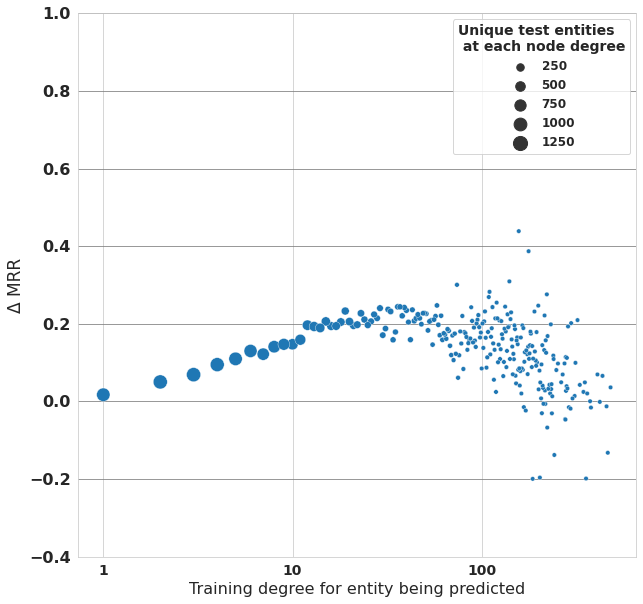

,degree,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,count,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,67.0,0.174061,0.395904,0.511945,0.617747,0.323485,293,0.075085,0.139932,0.225256,0.283276,0.141346,43,0.098976,0.255973,0.286689,0.334471,0.182140
1,61.0,0.193916,0.342205,0.425856,0.581749,0.305905,263,0.038023,0.072243,0.133080,0.228137,0.085021,46,0.155894,0.269962,0.292776,0.353612,0.220883
2,7.0,0.090008,0.172387,0.217391,0.282990,0.152639,1311,0.028223,0.031274,0.032799,0.034325,0.030723,905,0.061785,0.141114,0.184592,0.248665,0.121916


In [253]:
ENTITY_TYPE_W_ATTR_ENCODE = PROTEIN
BIOBLP_MODEL_ID = BIOBLP_P
ROTATE_MODEL_ID = ROTATE

test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde = NodeDegreeEvalAnalyser(train_triples=train,
                             rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)
test_triples_ent_w_attr_df = nde.prep_test_data(test_triples_incl_ent_prop)

merged_bioblpp_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                                                       bioblp_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][BIOBLP_MODEL_ID],
                                                                                       rotate_model_id=ROTATE_MODEL_ID,
                                                                                       rotate_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][ROTATE_MODEL_ID],
                                                                                       node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                                                       eval_on_node_endpoint=EVAL_NODE_HEAD,
                                                                                       test_triples=test_triples_ent_w_attr_df,
                                                                                       entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                                                       metric_name=INVERSE_HARMONIC_MEAN_RANK,
                                                                                      plot_title=False) 
merged_bioblpp_rotate_df[:3]

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


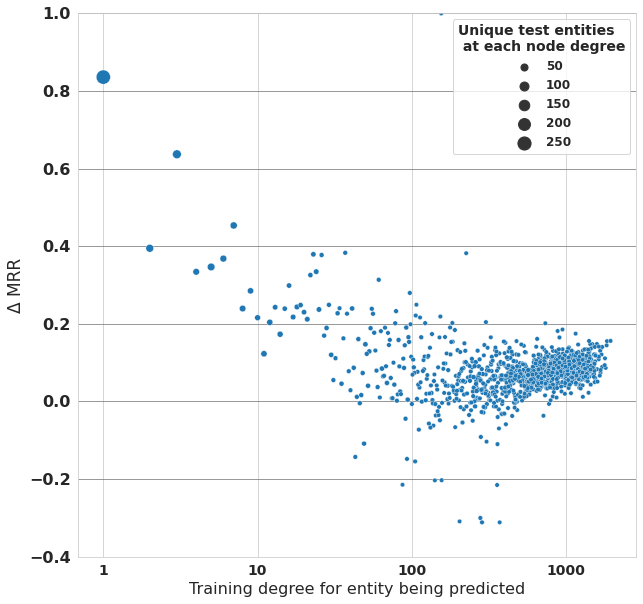

,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,429.0,80,0.062500,0.150000,0.187500,0.375000,0.147620,0.05,0.06250,0.062500,0.087500,0.071328,4,0.012500,0.087500,0.125000,0.287500,0.076292
1,269.0,27,0.000000,0.074074,0.148148,0.296296,0.084560,0.00,0.00000,0.037037,0.037037,0.027240,7,0.000000,0.074074,0.111111,0.259259,0.057320
2,733.0,92,0.097826,0.271739,0.347826,0.500000,0.219906,0.00,0.01087,0.021739,0.054348,0.018369,1,0.097826,0.260870,0.326087,0.445652,0.201537


In [251]:
ENTITY_TYPE_W_ATTR_ENCODE = DRUG
BIOBLP_MODEL_ID = BIOBLP_M
ROTATE_MODEL_ID = ROTATE

test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde = NodeDegreeEvalAnalyser(train_triples=train,
                             rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)
test_triples_ent_w_attr_df = nde.prep_test_data(test_triples_incl_ent_prop)


test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}


merged_bioblpm_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                                                       bioblp_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][BIOBLP_MODEL_ID],
                                                                                       rotate_model_id=ROTATE_MODEL_ID,
                                                                                       rotate_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][ROTATE_MODEL_ID],
                                                                                       node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                                                       eval_on_node_endpoint=EVAL_NODE_HEAD,
                                                                                       test_triples=test_triples_by_node_endpoint_to_predict[COL_SOURCE],#test_triples_ent_w_attr_df,
                                                                                       entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                                                       metric_name=INVERSE_HARMONIC_MEAN_RANK,
                                                                                      plot_title=False) 
merged_bioblpm_rotate_df[:3]

**DO NOT USE THE BIOBLP_D, USE THE BIOBLP_D_OLD VARIANT DEMONSTRATED AFTER THE IMMEDIATE CELL**

In [28]:
test_triples_ent_w_attr_df.rel.value_counts()

PROTEIN_DISEASE_ASSOCIATION    9760
DRUG_DISEASE_ASSOCIATION       6749
DISEASE_PATHWAY_ASSOCIATION     293
DISEASE_GENETIC_DISORDER        261
Name: rel, dtype: int64

### Predicting 'partner' entity, against 'partner' entity degree

In [241]:
eval_out_file_bioblpd_expt = './metrics/bioblpd-38uz9fjs-16-03-2023/20230425-073317/node-degree-eval.json'
with open(eval_out_file_bioblpd_expt, 'r') as f:
    results_by_node_degree_dicts_bioblpd_expt = json.load(f)
    
eval_out_file_rotate_disease_expt = './metrics/rotate-otxtubeb/20230425-083758/node-degree-eval.json'
with open(eval_out_file_rotate_disease_expt, 'r') as f:
    results_by_node_degree_dicts_rotate_disease_expt = json.load(f) 

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


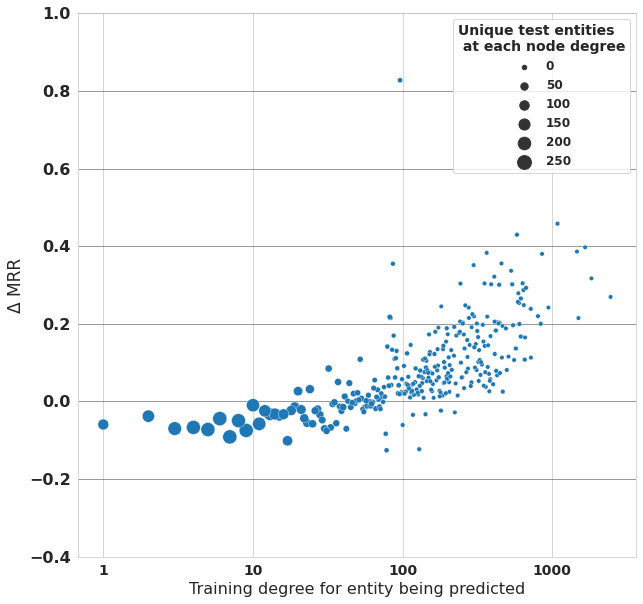

,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,464.0,46,0.260870,0.413043,0.413043,0.434783,0.357222,0.108696,0.195652,0.217391,0.239130,0.162678,0,0.152174,0.217391,0.195652,0.195652,0.194544
1,56.0,72,0.027778,0.069444,0.083333,0.208333,0.077358,0.041667,0.097222,0.152778,0.194444,0.091676,24,-0.013889,-0.027778,-0.069444,0.013889,-0.014317
2,180.0,27,0.074074,0.185185,0.222222,0.444444,0.179837,0.111111,0.259259,0.259259,0.333333,0.203343,3,-0.037037,-0.074074,-0.037037,0.111111,-0.023506


In [250]:
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE
BIOBLP_MODEL_ID = BIOBLP_D
ROTATE_MODEL_ID = ROTATE
METRIC_TO_PLOT = INVERSE_HARMONIC_MEAN_RANK


test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde = NodeDegreeEvalAnalyser(train_triples=train,
                             rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)
test_triples_ent_w_attr_df = nde.prep_test_data(test_triples_incl_ent_prop)

test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

merged_bioblpd_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                            bioblp_eval_results=results_by_node_degree_dicts_bioblpd_expt,
                                                            rotate_model_id=ROTATE_MODEL_ID,
                                                            rotate_eval_results=results_by_node_degree_dicts_rotate_disease_expt,
                                                            node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                            eval_on_node_endpoint='tail',
                                                            test_triples=test_triples_by_node_endpoint_to_predict[COL_SOURCE],
                                                            entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                            metric_name=METRIC_TO_PLOT,
                                                                                      plot_title=False) 
merged_bioblpd_rotate_df[:3]

In [238]:
eval_out_file_bioblpp_expt = './metrics/rotate-bioblp-p-4o6x9h96/20230425-105626/node-degree-eval.json'
with open(eval_out_file_bioblpp_expt, 'r') as f:
    results_by_node_degree_dicts_bioblpp_expt = json.load(f)
    
eval_out_file_rotate_prot_expt = './metrics/rotate-otxtubeb/20230425-173731/node-degree-eval.json'
with open(eval_out_file_rotate_prot_expt, 'r') as f:
    results_by_node_degree_dicts_rotate_prot_expt = json.load(f) 

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


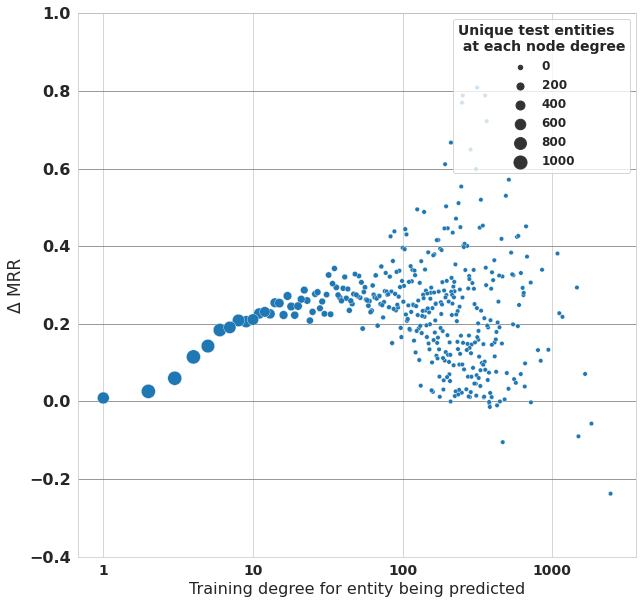

,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,59.0,262,0.202290,0.385496,0.477099,0.572519,0.323075,0.030534,0.091603,0.118321,0.160305,0.076199,53,0.171756,0.293893,0.358779,0.412214,0.246876
1,23.0,613,0.200653,0.394780,0.491028,0.613377,0.332018,0.034258,0.058728,0.092985,0.148450,0.071970,229,0.166395,0.336052,0.398042,0.464927,0.260049
2,60.0,243,0.246914,0.407407,0.506173,0.600823,0.359856,0.053498,0.115226,0.156379,0.197531,0.101204,44,0.193416,0.292181,0.349794,0.403292,0.258652


In [248]:
ENTITY_TYPE_W_ATTR_ENCODE = PROTEIN
BIOBLP_MODEL_ID = BIOBLP_P
ROTATE_MODEL_ID = ROTATE
METRIC_TO_PLOT = INVERSE_HARMONIC_MEAN_RANK


test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde = NodeDegreeEvalAnalyser(train_triples=train,
                             rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)
test_triples_ent_w_attr_df = nde.prep_test_data(test_triples_incl_ent_prop)

test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

merged_bioblpd_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                            bioblp_eval_results=results_by_node_degree_dicts_bioblpp_expt,
                                                            rotate_model_id=ROTATE_MODEL_ID,
                                                            rotate_eval_results=results_by_node_degree_dicts_rotate_prot_expt,
                                                            node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                            eval_on_node_endpoint='tail',
                                                            test_triples=test_triples_by_node_endpoint_to_predict[COL_SOURCE],
                                                            entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                            metric_name=METRIC_TO_PLOT,
                                                                                       plot_title=False
                                                                                      ) 
merged_bioblpd_rotate_df[:3]

In [11]:
eval_out_file_bioblpm_expt = './metrics/rotate-bioblp-m-1r75g9na/20230426-045049/node-degree-eval.json'
with open(eval_out_file_bioblpm_expt, 'r') as f:
    results_by_node_degree_dicts_bioblpm_expt = json.load(f)
    
eval_out_file_rotate_drug_expt = './metrics/rotate-otxtubeb/20230425-225516/node-degree-eval.json'
with open(eval_out_file_rotate_drug_expt, 'r') as f:
    results_by_node_degree_dicts_rotate_drug_expt = json.load(f) 

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


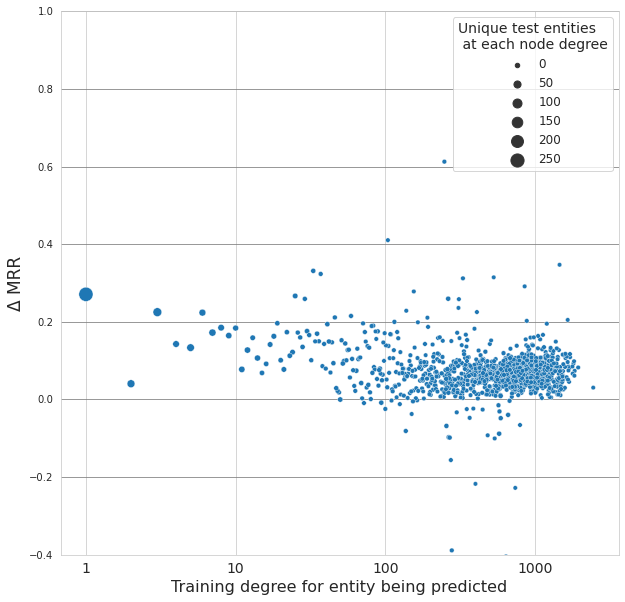

,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,796.0,122,0.024590,0.065574,0.090164,0.131148,0.073719,0.0,0.000000,0.000000,0.00000,0.002652,4,0.024590,0.065574,0.090164,0.131148,0.071067
1,569.0,344,0.020349,0.061047,0.110465,0.255814,0.092142,0.0,0.008721,0.011628,0.02907,0.019130,7,0.020349,0.052326,0.098837,0.226744,0.073012
2,1413.0,66,0.000000,0.030303,0.075758,0.121212,0.052167,0.0,0.000000,0.000000,0.00000,0.000571,2,0.000000,0.030303,0.075758,0.121212,0.051596


In [20]:
ENTITY_TYPE_W_ATTR_ENCODE = DRUG
BIOBLP_MODEL_ID = BIOBLP_M
ROTATE_MODEL_ID = ROTATE
METRIC_TO_PLOT = INVERSE_HARMONIC_MEAN_RANK


test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde = NodeDegreeEvalAnalyser(train_triples=train,
                             rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)
test_triples_ent_w_attr_df = nde.prep_test_data(test_triples_incl_ent_prop)

test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

merged_bioblpm_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                            bioblp_eval_results=results_by_node_degree_dicts_bioblpm_expt,
                                                            rotate_model_id=ROTATE_MODEL_ID,
                                                            rotate_eval_results=results_by_node_degree_dicts_rotate_drug_expt,
                                                            node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                            eval_on_node_endpoint='tail',
                                                            test_triples=test_triples_by_node_endpoint_to_predict[COL_SOURCE],
                                                            entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                            metric_name=METRIC_TO_PLOT,
                                                                                       plot_title=False
                                                                                      ) 
merged_bioblpm_rotate_df[:3]

In [34]:
eval_out_file_bioblpd_old = './metrics/bioblpd-38uz9fjs/node-degree-eval.json'
eval_out_file_bioblpd_old = './metrics/node_degree_eval_lp/spotlight_ent_as_src/node-degree-eval-bioblpd-38uz9fjs-spotlight-disease-as-src.json'
with open(eval_out_file_bioblpd_old, 'r') as f:
    results_by_node_degree_dicts_bioblpd_old = json.load(f)
    
eval_out_file_rotate_disease_as_src = './metrics/node_degree_eval_lp/spotlight_ent_as_src/node-degree-eval-rotate-otxtubeb-spotlight-disease-as-src.json'
with open(eval_out_file_rotate_disease_as_src, 'r') as f:
    results_by_node_degree_dicts_rotate_disease_src = json.load(f)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


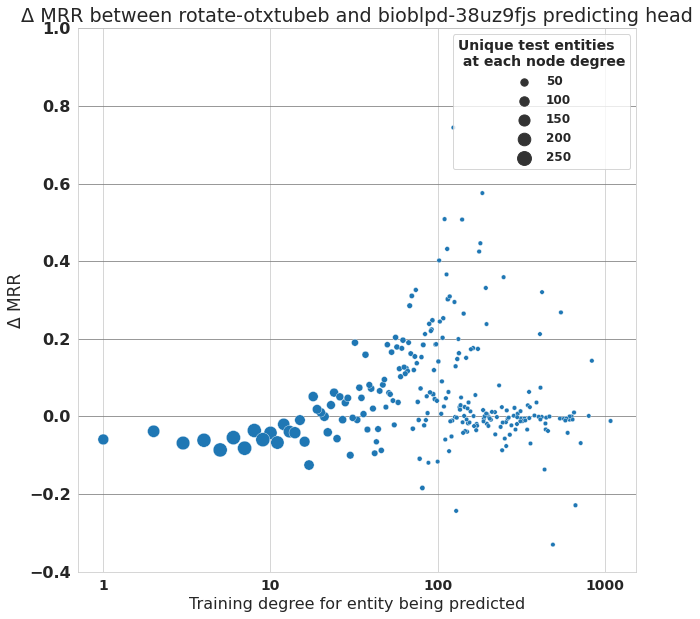

,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,arithmetic_mean_rank,adjusted_arithmetic_mean_rank,inverse_harmonic_mean_rank_bioblp,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,148.0,26,0.115385,0.269231,0.346154,0.461538,0.227222,546.261902,0.010306,0.076215,0.047619,0.047619,0.071429,0.142857,4,0.067766,0.221612,0.274725,0.318681,0.151008
1,4.0,291,0.020619,0.027491,0.037801,0.037801,0.028698,601.184204,0.011342,0.089921,0.052632,0.098684,0.105263,0.164474,254,-0.032013,-0.071193,-0.067462,-0.126673,-0.061223
2,2.0,207,0.000000,0.000000,0.000000,0.004831,0.002660,751.289856,0.014175,0.040792,0.007246,0.050725,0.072464,0.108696,189,-0.007246,-0.050725,-0.072464,-0.103865,-0.038132


In [249]:
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE
BIOBLP_MODEL_ID = BIOBLP_D_old
ROTATE_MODEL_ID = ROTATE
METRIC_TO_PLOT = INVERSE_HARMONIC_MEAN_RANK


test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde = NodeDegreeEvalAnalyser(train_triples=train,
                             rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)
test_triples_ent_w_attr_df = nde.prep_test_data(test_triples_incl_ent_prop)

test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

merged_bioblpd_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                            bioblp_eval_results=results_by_node_degree_dicts_bioblpd_old,
                                                            rotate_model_id=ROTATE_MODEL_ID,
                                                            rotate_eval_results=results_by_node_degree_dicts_rotate_disease_src,
                                                            node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                            eval_on_node_endpoint=EVAL_NODE_HEAD,
                                                            test_triples=test_triples_by_node_endpoint_to_predict[COL_SOURCE],
                                                            entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                            metric_name=METRIC_TO_PLOT) 
merged_bioblpd_rotate_df[:3]

In [16]:
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE
BIOBLP_MODEL_ID = BIOBLP_D_old
ROTATE_MODEL_ID = ROTATE
METRIC_TO_PLOT = INVERSE_HARMONIC_MEAN_RANK


test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

merged_bioblpd_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                            bioblp_eval_results=results_by_node_degree_dicts_bioblpd_old,
                                                            rotate_model_id=ROTATE_MODEL_ID,
                                                            rotate_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][ROTATE_MODEL_ID],
                                                            node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                            eval_on_node_endpoint=EVAL_NODE_HEAD,
                                                            test_triples=test_triples_by_node_endpoint_to_predict[COL_SOURCE],
                                                            entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                            metric_name=METRIC_TO_PLOT) 
merged_bioblpd_rotate_df[:3]

NameError: name 'results_by_node_degree_dicts_bioblpd_old' is not defined

In [208]:
### plot metrics

In [25]:
import matplotlib.pyplot as plt
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_single_model
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_multi_models

img_outdir = Path('./data/imgs/')


note,not all the cells have been amended after changing the structure of the eval results dictionary to store 'head', 'tail', 'both', results,
so if you face an error whilst plotting, try accessing the dictionaries at the 'head', 'tail', or 'both' keys of the results_dictionaries directly. E.g. results_by_node_degree_dicts_rotate_drug['head'] insetead of 'tail'


In [26]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpp"
model_result_dicts = {ROTATE: results_by_node_degree_dicts_rotate_prot[EVAL_NODE_HEAD],
                     BIOBLP_P: results_by_node_degree_dicts_bioblpp[EVAL_NODE_HEAD]}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=HITS_AT_10, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


NameError: name 'results_by_node_degree_dicts_rotate_prot' is not defined

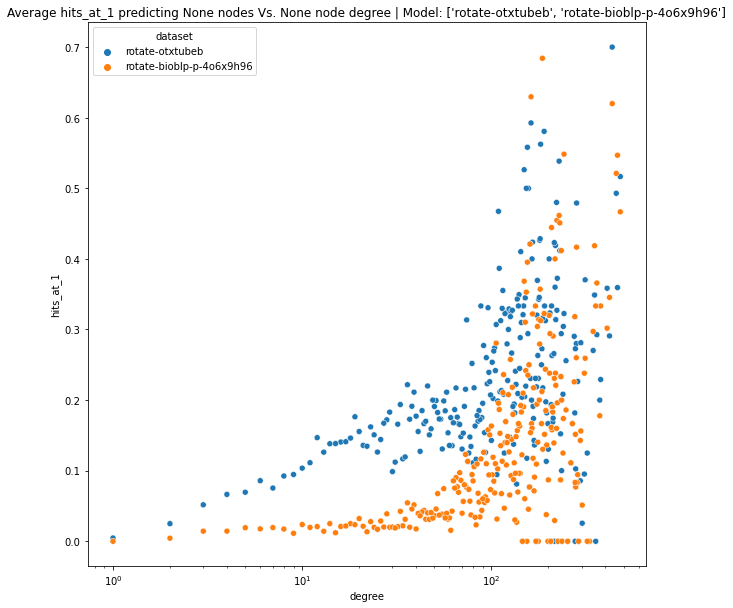

In [43]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpp"
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=HITS_AT_1, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


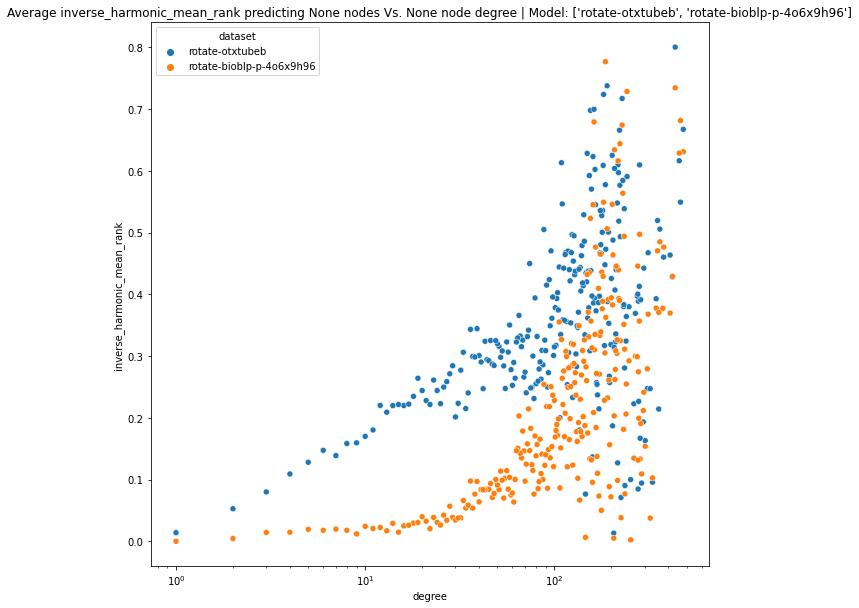

In [46]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpp"
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=INVERSE_HARMONIC_MEAN_RANK, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


In [45]:
#molecules

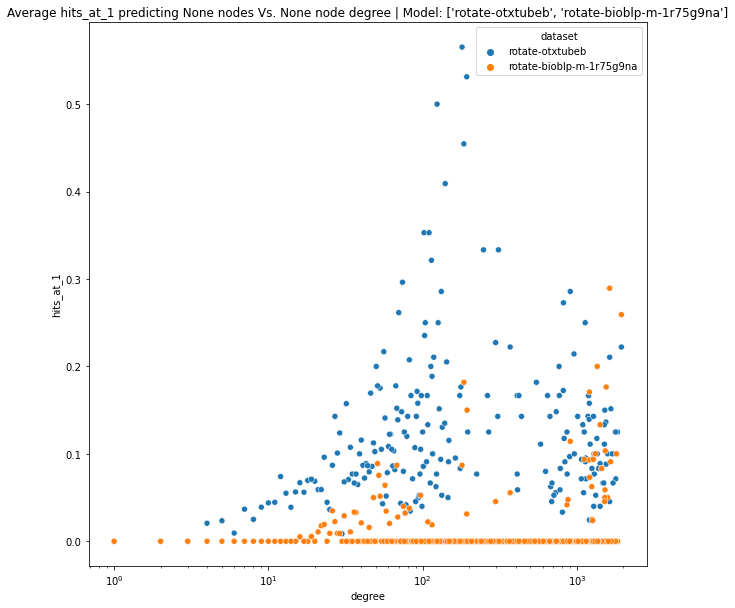

In [77]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpm"
model_result_dicts = {ROTATE: results_by_node_degree_dicts_rotate_drug[EVAL_NODE_HEAD],
                     BIOBLP_M: results_by_node_degree_dicts_bioblpm[EVAL_NODE_HEAD]}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=HITS_AT_1, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


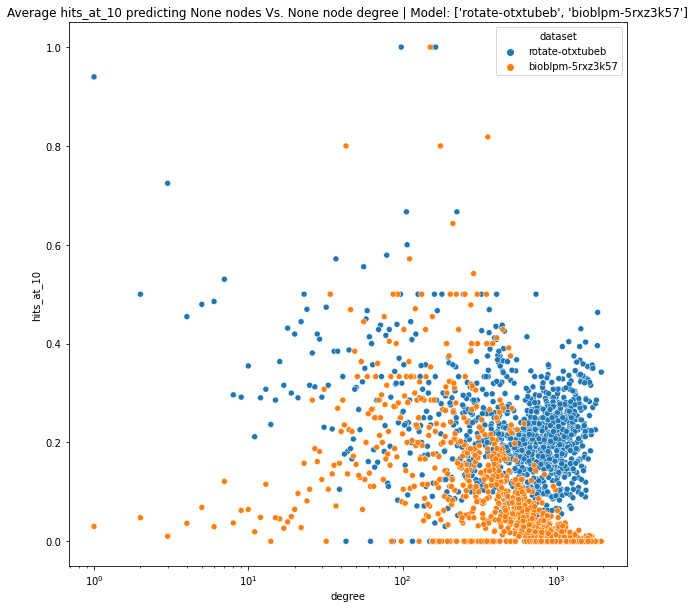

In [238]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpm"
model_result_dicts = {ROTATE: results_by_node_degree_dicts_rotate_drug[EVAL_NODE_HEAD],
                     BIOBLP_M: results_by_node_degree_dicts_bioblpm[EVAL_NODE_HEAD]}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=HITS_AT_10, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


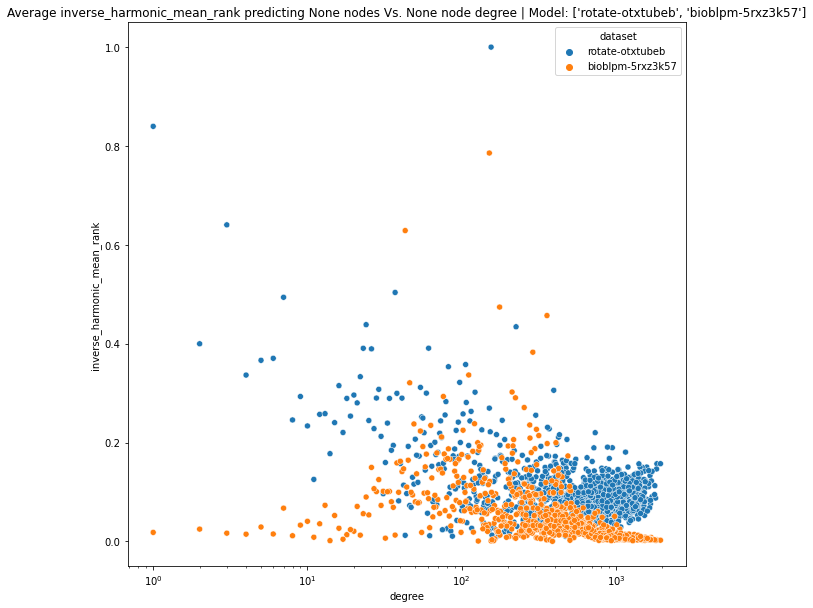

In [239]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpm"
model_result_dicts = {ROTATE: results_by_node_degree_dicts_rotate_drug[EVAL_NODE_HEAD],
                     BIOBLP_M: results_by_node_degree_dicts_bioblpm[EVAL_NODE_HEAD]}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=INVERSE_HARMONIC_MEAN_RANK, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)



#### previous stuff

In [98]:
wandb.login()

True

In [99]:
tags = {"model_name": BIOBLP_M),
        "study_name": 'node_degree_trends_both_models_combined',
        "test_set_type": TEST_RESTRICTED_ENT}
run = setup_wandb_result_tracker(**tags, 
                                 notes=f'combined lp results for {BIOBLP_M)} and {MODELS.get(ROTATE)}', 
                                 project_name='bioblp-jupyter-trial',
                                 wandb_entity='discoverylab')

Save custom plots to Weights and biases

In [117]:
!ls {EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}

20230324-173105-hits_at_1_node_degree_analysis-rotate-otxtubeb-20230324-173105.png
20230324-173137-hits_at_10_node_degree_analysis-rotate-otxtubeb-20230324-173137.png
20230324-173248-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-20230324-173248.png
20230324-173341-hits_at_1_node_degree_analysis-bioblpp-cttc3ucm-20230324-173341.png
20230324-173404-hits_at_10_node_degree_analysis-bioblpp-cttc3ucm-20230324-173404.png
20230324-173426-inverse_harmonic_mean_rank_node_degree_analysis-bioblpp-cttc3ucm-20230324-173426.png
20230324-174518-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png
20230324-174536-hits_at_10_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png
20230324-174539-hits_at_1_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png


In [120]:
#degree_analysis_hits_at_1_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174539-hits_at_1_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"
#degree_analysis_hits_at_10_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174536-hits_at_10_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"
degree_analysis_mrr_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174518-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"

wandb.log({"hits@1_combined_bioblpm_rotate": wandb.Image(degree_analysis_hits_at_1_rotate_and_bioblpm_path)})
wandb.log({"hits@10_combined_bioblpm_rotate": wandb.Image(degree_analysis_hits_at_10_rotate_and_bioblpm_path)})
wandb.log({"mrr_combined_bioblpm_rotate": wandb.Image(degree_analysis_mrr_rotate_and_bioblpm_path)})